<h2>Classification </h2>
- Classify counties into different categories based on their unemployment rates (e.g., low, medium, high). <br>

In [2]:
import pandas as pd
import numpy as np

In [3]:
mergedData = pd.read_csv('AnalysisOut.csv')

In [4]:
#determine low, medium, and high unemployment rates
CalUnemp_rate = mergedData[mergedData['State'] == 'CA']
CalUnemp_rate['Unemployment Rate (%)'].describe()



count    522.000000
mean       6.550766
std        3.084095
min        2.100000
25%        4.500000
50%        5.950000
75%        7.975000
max       24.600000
Name: Unemployment Rate (%), dtype: float64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from dmba import plotDecisionTree, classificationSummary

#determine thresholds
low = 4.5
medium = 8

#create a new column for unemployment rate category
mergedData['Unemployed Rate Category'] = pd.cut(mergedData['Unemployment Rate (%)'], bins=[0, low, medium, float('inf')], labels=['Low', 'Medium', 'High'])

#set County code as index for later retrieval
mergedData.set_index('County Code', inplace=True)

#CalUnemp_rate: need to reset index later to get the county name
CalUnemp_rate = mergedData[mergedData['State'] == 'CA']

#1. selecting features
x = CalUnemp_rate[['Labor Force', 'Employed', 'Unemployed']]
y = CalUnemp_rate['Unemployed Rate Category']

#2. split test/train
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=0)

#3. classify tree
tree = DecisionTreeClassifier(criterion='gini',max_depth=3, random_state=1, min_impurity_decrease= 0.01)
tree.fit(train_X, train_y)

#make predict
y_pred = tree.predict(test_X)

#for each county in CA and their prediction vs actual
comparison = test_X.copy() #make a copy of the test data
comparison['Prediction'] = y_pred #add the prediction column
comparison['Actual'] = test_y #add the actual column

#reset the index for CalUnemp_rate to get the county name
CalUnemp_rate_reset = CalUnemp_rate.reset_index() 
comparison['County'] = CalUnemp_rate_reset.loc[test_X.index, 'County Name/State Abbreviation'] #add the county column

comparison



no display found. Using non-interactive Agg backend


,Labor Force,Employed,Unemployed,Prediction,Actual,County
County Code,,,,,,
17.0,92350.0,89173.0,3177.0,Medium,Low,"Lassen County, CA"
29.0,393736.0,360971.0,32765.0,High,High,"Orange County, CA"
35.0,10363.0,9642.0,721.0,Medium,Medium,"San Bernardino County, CA"
21.0,12803.0,11840.0,963.0,Medium,Medium,"Mariposa County, CA"
97.0,246535.0,238693.0,7842.0,Low,Low,"San Luis Obispo County, CA"
...,...,...,...,...,...,...
25.0,71538.0,55364.0,16174.0,Medium,High,"Mono County, CA"
85.0,1010149.0,961615.0,48534.0,Medium,Medium,"Napa County, CA"
105.0,5141.0,4739.0,402.0,Medium,Medium,"Solano County, CA"


<h3> Decision Tree </h3>

Plot the decision tree

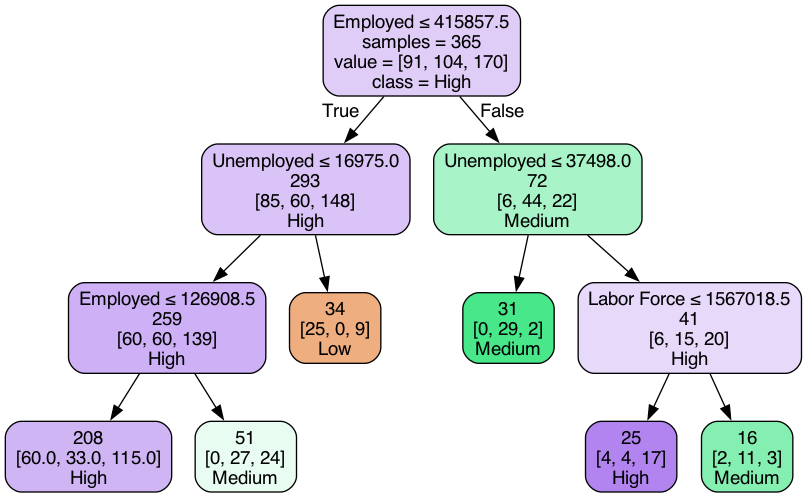

In [6]:
#plot the tree
plotDecisionTree(tree, feature_names=train_X.columns, class_names=['Low', 'Medium', 'High'])

#from the observation, the most important feature is employment, followed by unemployed and labor force.

In [7]:
#confusion matrix for testing sample versus prediction sample
classificationSummary(train_y, tree.predict(train_X))
classificationSummary(test_y, tree.predict(test_X))


Confusion Matrix (Accuracy 0.6137)

       Prediction
Actual   0   1   2
     0  25   2  64
     1   0  67  37
     2   9  29 132
Confusion Matrix (Accuracy 0.5924)

       Prediction
Actual  0  1  2
     0 12  0 24
     1  2 18 18
     2  6 14 63


Accuracy of the classification based on Decision Tree is about 59% which is closed to the training data (61%). However, we can try using Random Forest to improve this accuracy for better prediction.

<h3> Random Forest </h3>

In [8]:
#random forest
rf = RandomForestClassifier(n_estimators=500, random_state=1, max_depth=6, min_impurity_decrease=0.01)
rf.fit(train_X, train_y)

#plotting feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

#print the results of feature importance variables
out = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
out = out.sort_values('importance', ascending=False)
print(out)

       feature  importance       std
2   Unemployed    0.374257  0.165984
1     Employed    0.320372  0.212552
0  Labor Force    0.305371  0.213126


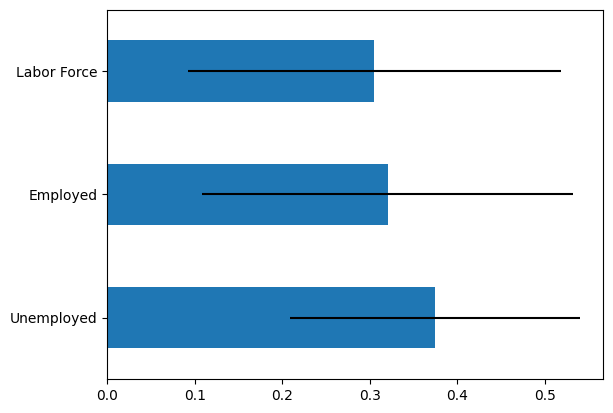

In [9]:
#plotting the feature importance
%matplotlib inline
import matplotlib.pyplot as plt

ax = out.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.show()

Based on the feature importance table, Unemployment is the most important feature used for classification on identifying unemployment type.
Variable of importance is indicated by the reduction of Gini index (purest form)

In [10]:
classificationSummary(train_y, rf.predict(train_X)) #training 
classificationSummary(test_y, rf.predict(test_X)) #testing set

Confusion Matrix (Accuracy 0.7151)

       Prediction
Actual   0   1   2
     0  39   2  50
     1   0  67  37
     2   2  13 155
Confusion Matrix (Accuracy 0.6433)

       Prediction
Actual  0  1  2
     0 16  0 20
     1  0 18 20
     2  6 10 67


The accuracy improved to 64%, but there is certainty of overfitting as training set accuracy is about 71%. Using Boosting method to train on misclassified data. 

<h4> Boosting Method </h4>

In [11]:
#boosting
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)

#classification summary for training and testing set
classificationSummary(train_y, boost.predict(train_X))
classificationSummary(test_y, boost.predict(test_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1   2
     0  91   0   0
     1   0 104   0
     2   0   0 170
Confusion Matrix (Accuracy 0.8280)

       Prediction
Actual  0  1  2
     0 27  0  9
     1  0 30  8
     2  4  6 73


We improved the accuracy of the testing data using Boosting method, however, there is a large difference in the accuracy compare to the training data. I can try to use cross-validation method to get a robust eestimate of the model and reduce overfitting to the training set.

<h4>Grid Search method</h4>

In [12]:
from sklearn.model_selection import GridSearchCV

#define parameters
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50],
    'min_impurity_decrease': [0.001, 0.01, 0.1]
}

#grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_X, train_y)

#best parameters
best_params = grid_search.best_params_
print(best_params)


{'max_depth': 20, 'min_impurity_decrease': 0.001, 'n_estimators': 500}


In [13]:
#using best parameters for random forest
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(train_X, train_y)

classificationSummary(train_y, rf_best.predict(train_X))
classificationSummary(test_y, rf_best.predict(test_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1   2
     0  91   0   0
     1   0 104   0
     2   0   0 170
Confusion Matrix (Accuracy 0.8408)

       Prediction
Actual  0  1  2
     0 26  0 10
     1  0 32  6
     2  4  5 74


We have improved our testing model accuracy up to 84%.